## 1. Introduction to Anomaly Detection and PLAsTiCC
#### Alex Gagliano (gaglian2@mit.edu), IAIFI - January 8th, 2024

An exciting aspect of astrophysics is the potential to make new and unexpected discoveries. As increasing data volumes force our exploration techniques to become increasingly automated, more and more attention is being directed to _anomaly detection_: the detection of rare or unusual events. For most of us, it's also important to distinguish _astrophysical_ outliers (like a new type of galaxy) from _non-astrophysical_ ones (like an artifact from a saturated detector).

Unsurprisingly, our definition of what constitutes an 'unusual event' is specific to our science goals and the data that we've collected. Generally speaking, we can define an anomaly as a data instance that lies `out-of-distribution' relative to some data space. This could be a: 
* _Point Anomaly:_ A single anomalous observation (a picture of an elliptical galaxy in a dataset of 10,000 spiral galaxies).
* _Contextual/Conditional Anomaly:_  A data instance that is anomalous in a particular context (a metal-poor star in a galaxy of mostly metal-rich stars).
* _Group Anomaly:_ A group of observations which collectively represent an anomaly, though the individual instances may not be rare or unusual (e.g., an overabundance of type Ia supernoavae toward a galaxy cluster).

These descriptions are nebulous and overlapping! It's important to consider how you might define an anomaly for your use case. For now, let's look at a dataset that will help us explore anomaly detection.

We'll use data from the [Photometric LSST Astronomical Time-Series Classification Challenge (PLAsTICC)](https://plasticc.org/), a [Kaggle](https://www.kaggle.com/)-run challenge that concluded in 2018. The dataset consists of photometry and metadata for transient and variable phenomena in the night sky, simulated to mimic the first three years of the Vera Rubin Observatory's [Legacy Survey for Space and Time](https://www.lsst.org/about). 

Let's download and look at the data. (Warning - the files are about 1 GB compressed, and ~2 uncompressed!)

In [1]:
import subprocess 
import gdown #needs to be version 4.6.0 to download large files!

In [3]:
gdown.download('https://drive.google.com/uc?id=1Cr3ez5a535WUazcG0ldoHpSTFCDx2Dap', '../data.zip')
subprocess.run("cd .. && unzip data.zip", shell=True)

Downloading...
From: https://drive.google.com/uc?id=1Cr3ez5a535WUazcG0ldoHpSTFCDx2Dap
To: /Users/alexgagliano/Documents/Conferences/MLHackWeek_Jan24/iaifi-hackathon-2023/anomaly_detection/data.zip
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.04G/1.04G [04:36<00:00, 3.76MB/s]


'../data.zip'

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

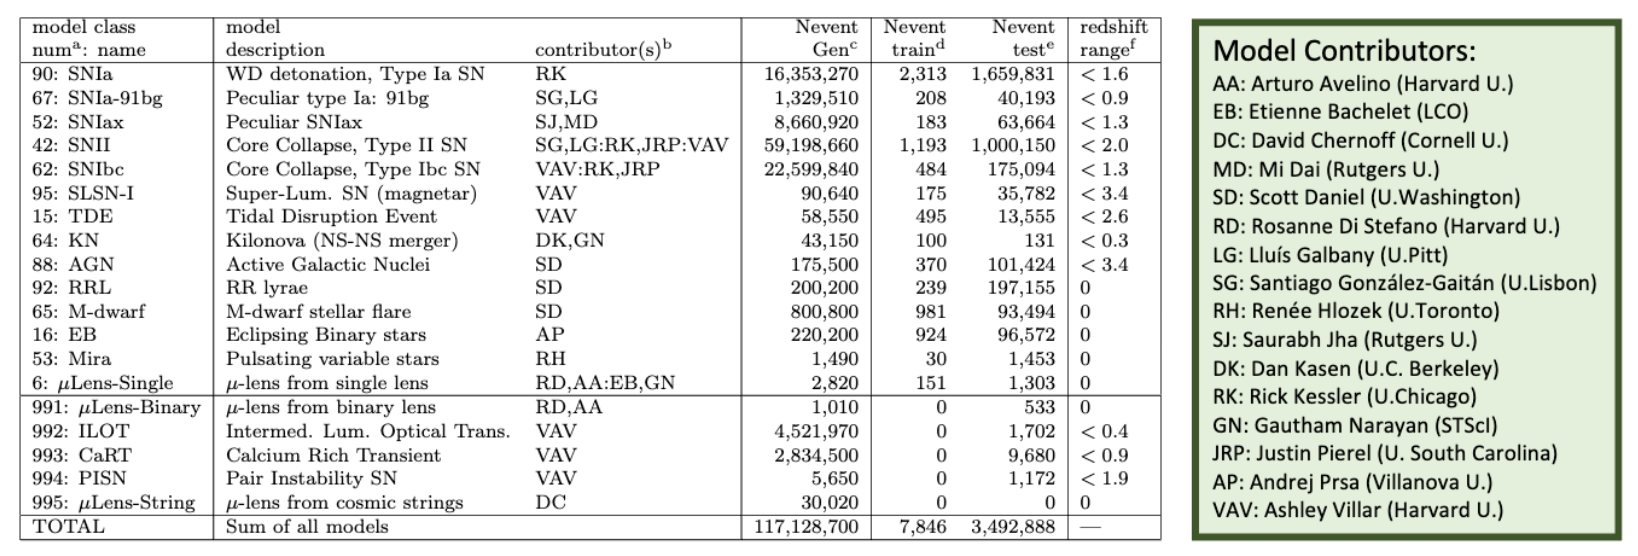

In [14]:
#What transient classes were simulated? - from https://zenodo.org/records/2539456
Image(filename='../plots/PLAsTiCCModels.png', width=1024)

In [15]:
dftrain_metadata = pd.read_csv("../data/plasticc_train_metadata.csv")

model_nums = {90:'SN Ia', 67:'SNIa-91bg', 52:'SNIax', 42:'SNII', 62:'SNIbc', 95:'SLSN-I', 15:'TDE', 64:'KN', 88:'AGN', 92:'RRL', 65:'M-dwarf', 16:'EB', 53:'Mira', 6:'muLens-Single', 991:'muLens-Binary', 992:'ILOT', 993:'CaRT', 994:'PISN', 995:'muLens-String'}

dftrain_metadata['target_names'] = dftrain_metadata['target'].map(model_nums)

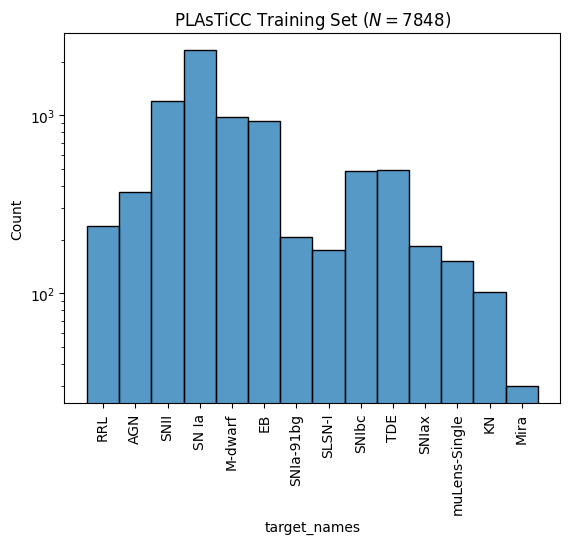

In [16]:
sns.histplot(dftrain_metadata['target_names'])
plt.yscale("log")
plt.xticks(rotation=90);
plt.title("PLAsTiCC Training Set ($N=%i$)"%len(dftrain_metadata));

We can see that the training set contains nearly 8k transient events, though there is a substantial imbalance between classes (30 Mira variables to 2,313 SNe Ia).

What metadata do we have for each transient event? 

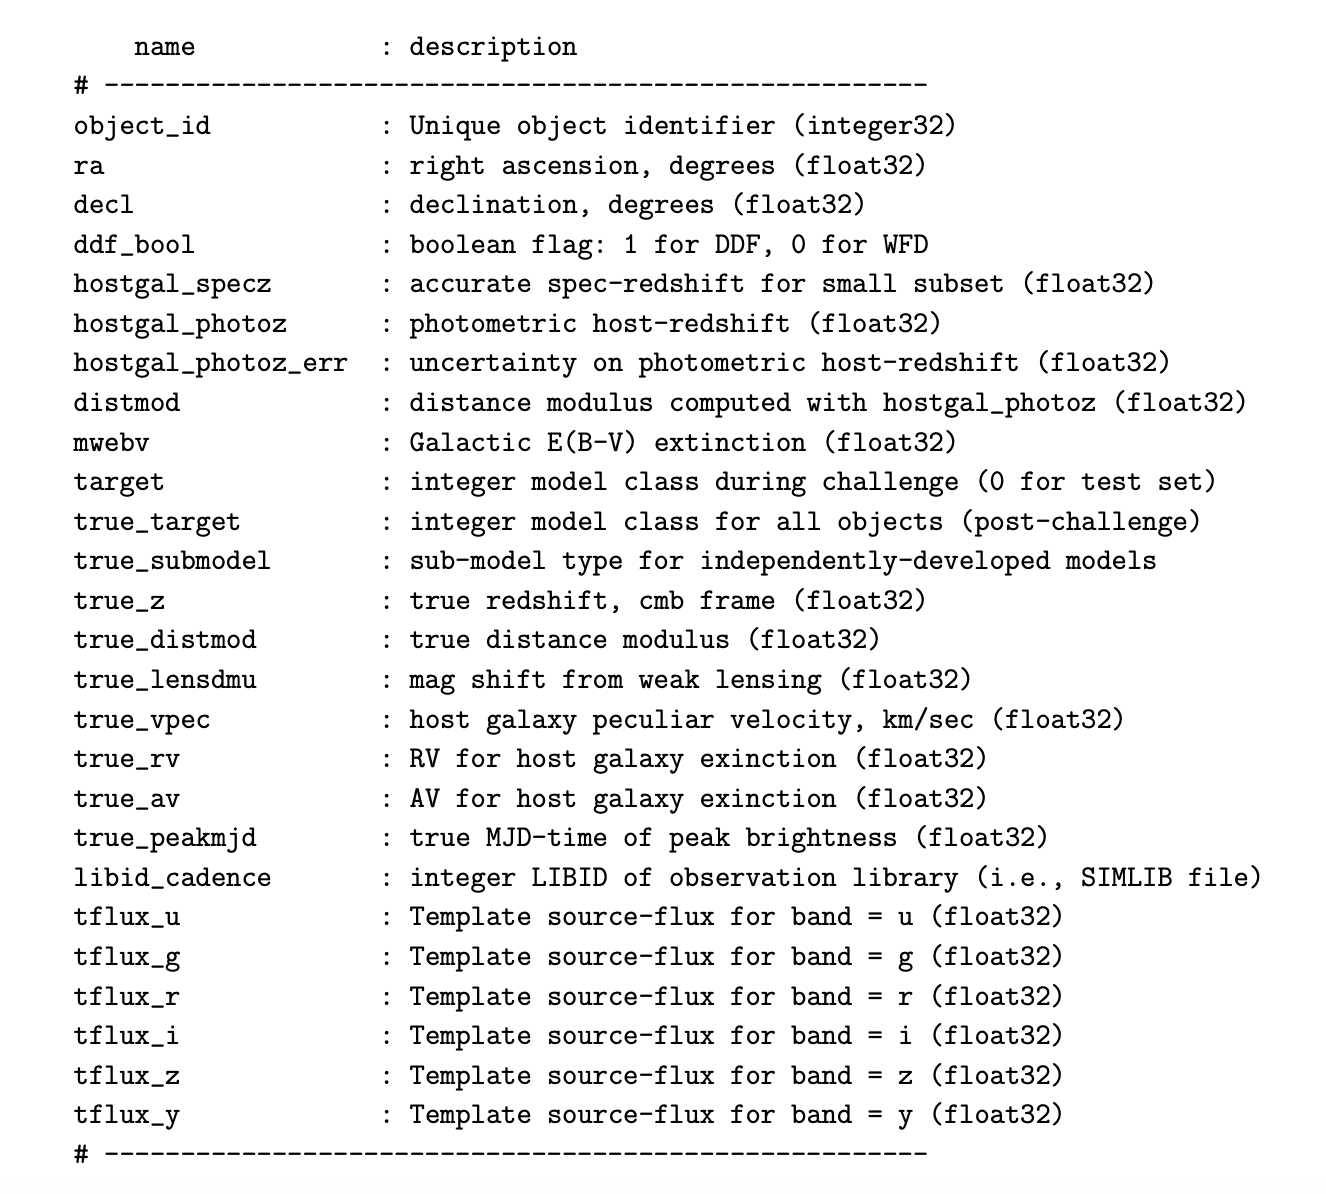

In [18]:
Image(filename='../plots/MetadataTable.png', width=512)

Because these are the truth tables, we have access to both the realistically-corrupted values (like the photometric redshift, `hostgal_photoz` with 68\% uncertainty `hostgal_photoz_err`), the small subset of transients for which we might have spectroscopic redshifts (`hostgal_specz`), and the true values (`true_z`). How do these compare? 

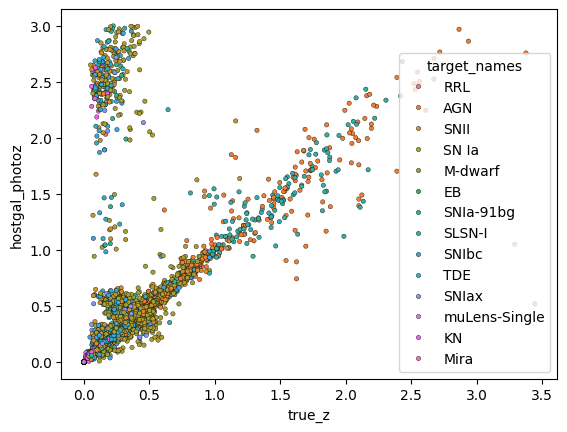

In [19]:
sns.scatterplot(x=dftrain_metadata['true_z'], y=dftrain_metadata['hostgal_photoz'], hue=dftrain_metadata['target_names'], ec='k', s=10);

We can see a few things: 
1. *Our photometric redshift method can fail catastrophically at low-$z$.* This comes from an astrophysical degeneracy - nearby red galaxies can have the same color as distant blue ones. We should be careful about this when trying to find anomalies by brightness.
2. *The composition of transients varies as a function of distance.* This is a combination of intrinsic event rates (Type Ia supernovae are more common than kilonovae in nature) and our selection function (SLSNe-I are superluminous supernovae - extremely bright by definition, which is why we can see them to such high distances). We note, however, that the composition of the training set is _not_ meant to be realistic; variable stars are underrepresented for simplicity, and no bogus alerts (artifacts) were simulated. 

One final note: the PLAsTICC data contains an artifact that makes it unrealistically easy to distinguish galactic sources (like variable stars) from extragalactic ones (like supernovae): 

In [20]:
dftrain_metadata.loc[dftrain_metadata['target_names'] == 'Mira', 'hostgal_photoz']

810     0.0
1660    0.0
1717    0.0
1783    0.0
2172    0.0
2259    0.0
2283    0.0
2822    0.0
2894    0.0
3018    0.0
3206    0.0
3589    0.0
4519    0.0
4655    0.0
5312    0.0
5426    0.0
6183    0.0
6195    0.0
6362    0.0
6389    0.0
6443    0.0
6687    0.0
6733    0.0
6753    0.0
6843    0.0
7080    0.0
7108    0.0
7256    0.0
7307    0.0
7608    0.0
Name: hostgal_photoz, dtype: float64

In reality, this will be a non-trivial task.

Now let's look at light curves.

In [24]:
lcs = pd.read_csv("../data/plasticc_train_lightcurves.csv")

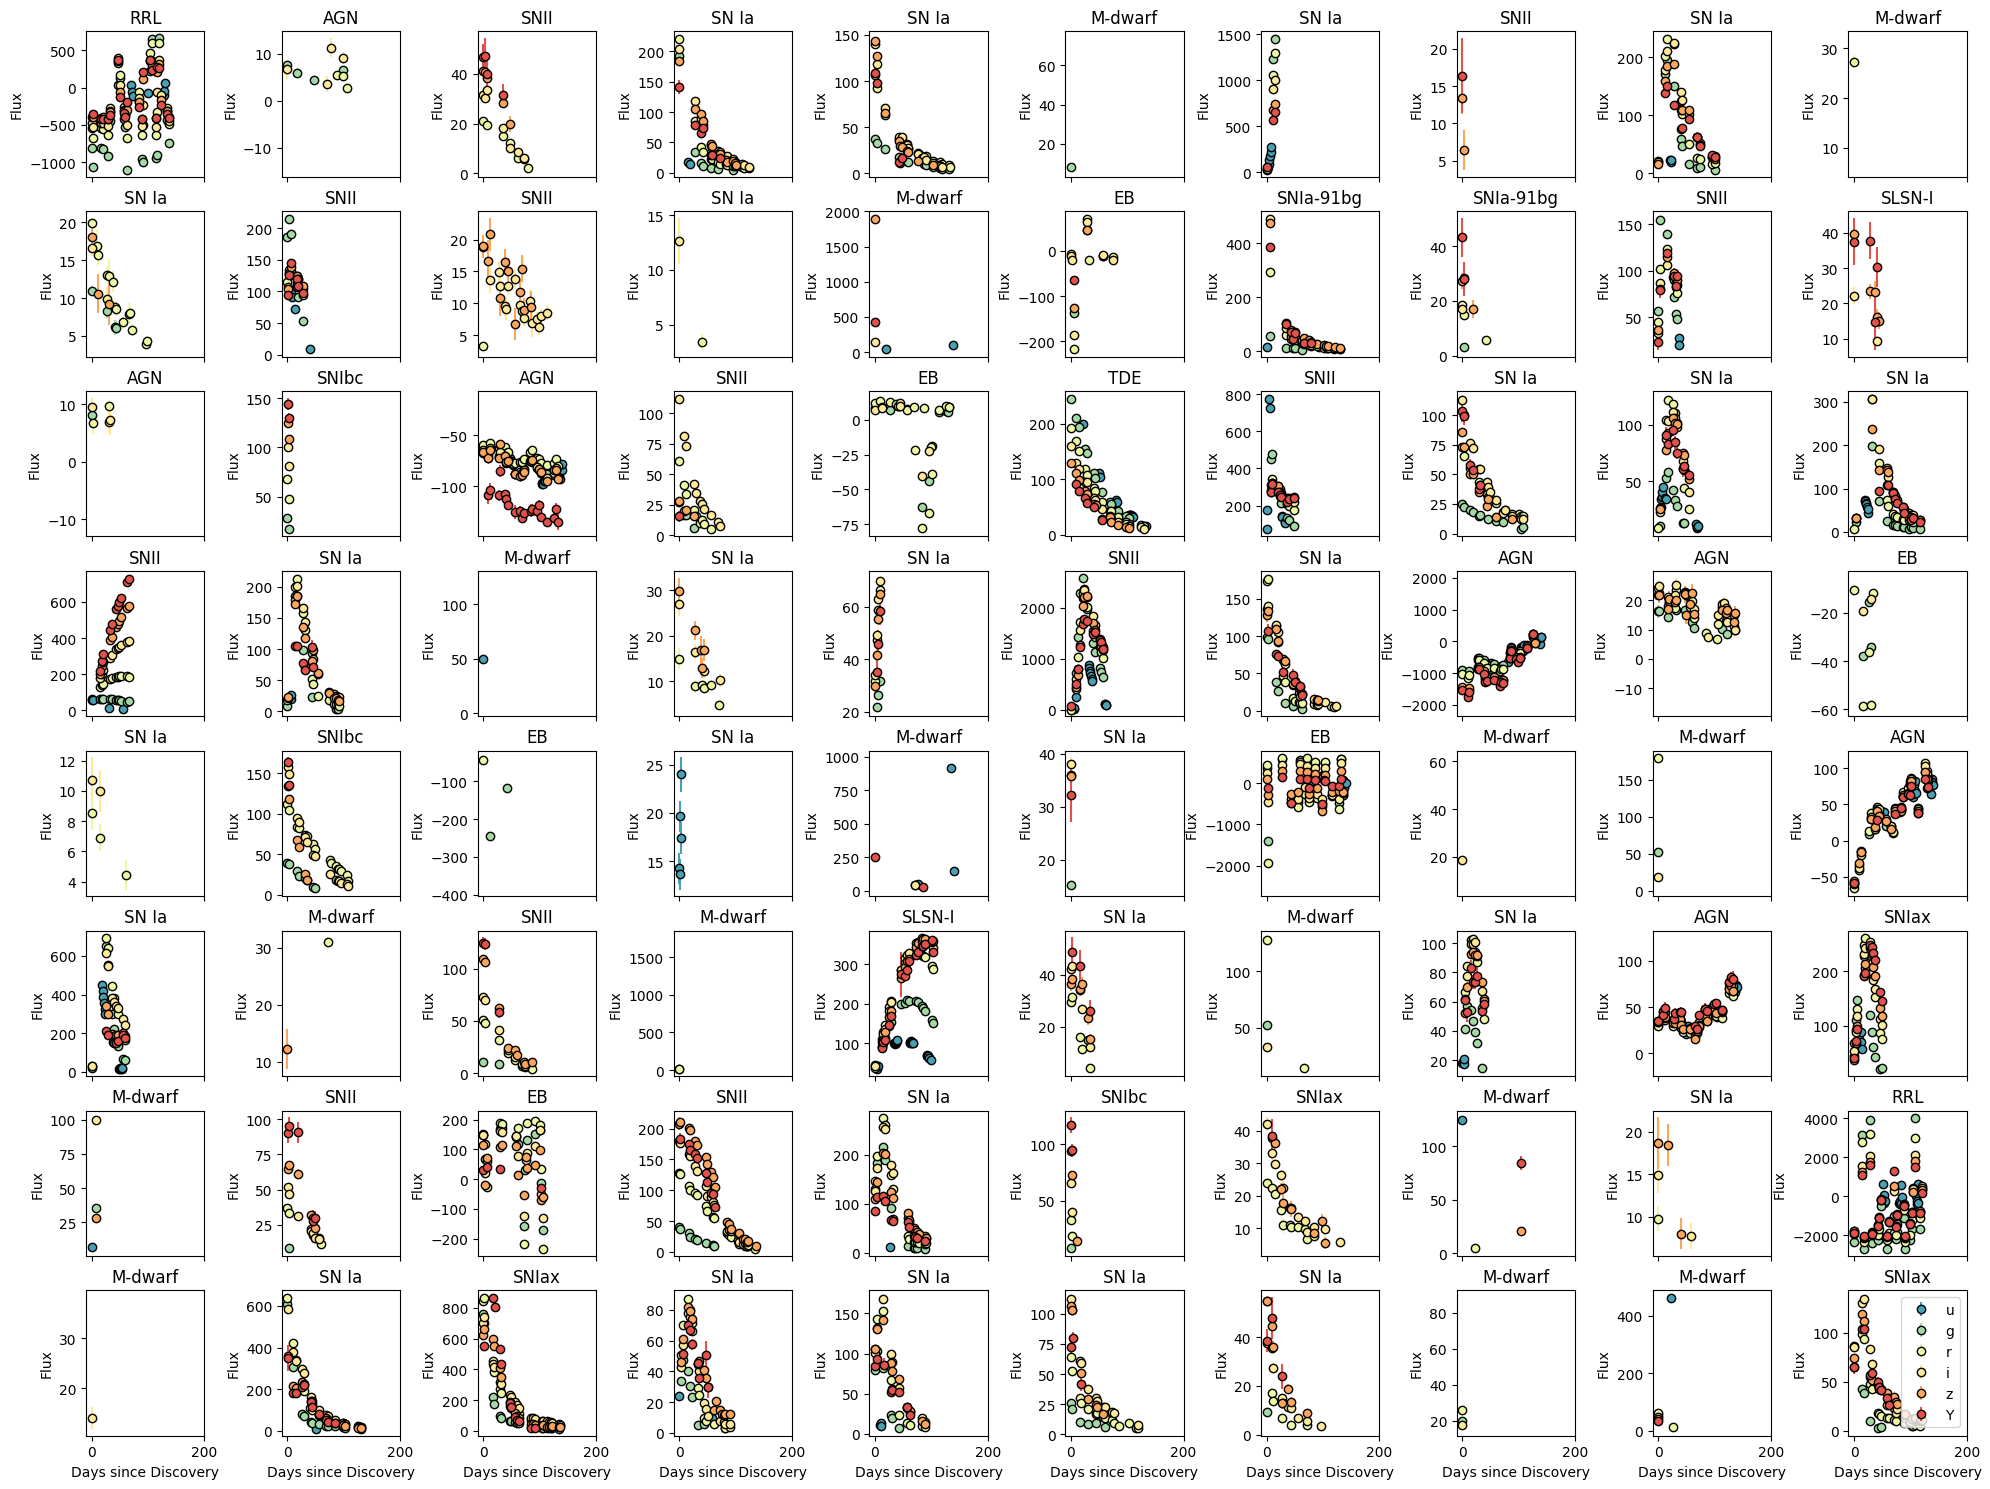

In [25]:
#map passband idx to passband name
lcs['passband_name'] = ["ugrizY"[i] for i in lcs['passband']]
lcs_detected = lcs[lcs['detected_bool'] == True]
cols = sns.color_palette("Spectral_r", 6)
VRO_bands = "ugrizY"

transients = np.unique(lcs_detected['object_id'])


fig, axs = plt.subplots(8, 10, figsize=(20, 15), sharex=True, sharey=False)
axs = axs.ravel()

for j in np.arange(80):
    transient = transients[j]
    lc = lcs_detected[lcs_detected['object_id'] == transient]
    for i in np.arange(len(VRO_bands)):
        band = VRO_bands[i]
        lc_band = lc[lc['passband_name'] == band]
        axs[j].errorbar(lc_band['mjd'] - np.nanmin(lc['mjd']), lc_band['flux'], yerr=lc_band['flux_err'], fmt='o', mec='k', c=cols[i], label=band)
    axs[j].set_ylabel("Flux")
    axs[j].set_title(dftrain_metadata.loc[dftrain_metadata['object_id'] == transient, 'target_names'].values[0])
axs[-1].legend()
axs[0].set_xlim((-10, 200));
for idx in np.arange(70, 80):
    axs[idx].set_xlabel("Days since Discovery");
fig.tight_layout(w_pad=0.1, h_pad=0.3)

We can already see some obvious differences in timescale and in brightness between VRO passbands! To better see this, let's convert from observer to rest-frame and from flux to magnitude, using the photometric redshift from the host galaxy. 

/var/folders/y1/n43fk0m97tg8sbqh5j222kqw0000gn/T/ipykernel_91191/2902166497.py:3: RuntimeWarning: invalid value encountered in log10
  merged_df['apparent_mag'] = zpt - 2.5*np.log10(merged_df['flux'].values)
/Users/alexgagliano/miniconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/alexgagliano/miniconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


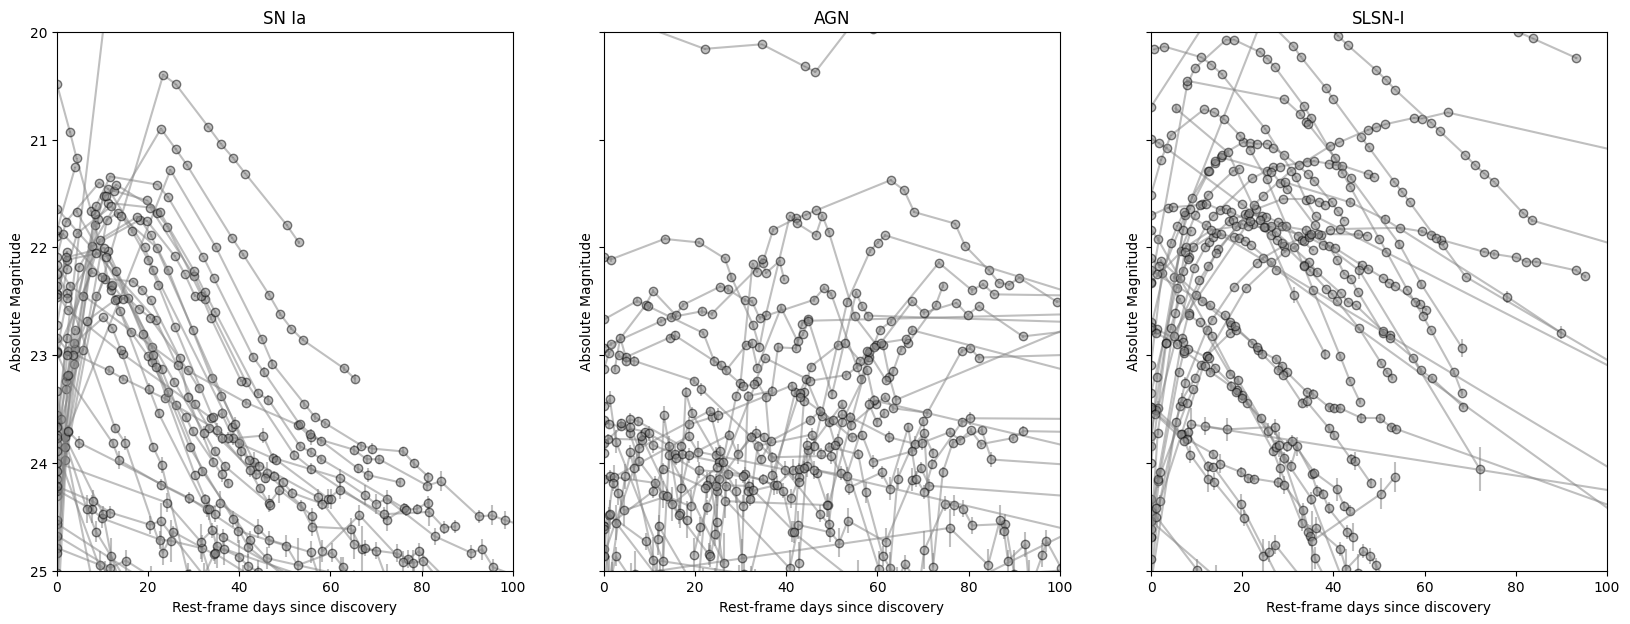

In [26]:
zpt = 27.5
merged_df = lcs_detected.merge(dftrain_metadata)
merged_df['apparent_mag'] = zpt - 2.5*np.log10(merged_df['flux'].values)
merged_df['mag_err'] = 1.0857 * np.abs(merged_df['flux_err'].values/merged_df['flux'].values)

fig, axs = plt.subplots(1,3, figsize=(20,7), sharey=True, sharex=True);
axs = axs.ravel()
tClasses = ['SN Ia', 'AGN', 'SLSN-I']

band = 'r'
for i in np.arange(len(tClasses)):
    tClass = tClasses[i]
    transientDF = merged_df[merged_df['target_names'] == tClass]
    for transient_id in np.unique(transientDF['object_id'])[0:50]:
        lc = transientDF[transientDF['object_id'] == transient_id]
        lc_band = lc[lc['passband_name'] == band]
        axs[i].errorbar((lc_band['mjd'] - np.nanmin(lc['mjd']))/(1+lc_band['hostgal_photoz']), lc_band['apparent_mag'], yerr=lc_band['mag_err'], fmt='o-', mec='k', c='gray', label=band, alpha=0.5)
        axs[i].set_xlabel("Rest-frame days since discovery")
        axs[i].set_ylabel("Absolute Magnitude")
        axs[i].set_title(tClasses[i])
axs[0].set_xlim((0, 100));
axs[0].set_ylim((25, 20));

This is apparent magnitude - are the differences more prominent once we correct for redshift? 

/var/folders/y1/n43fk0m97tg8sbqh5j222kqw0000gn/T/ipykernel_91191/2666115293.py:3: RuntimeWarning: invalid value encountered in log10
  merged_df['abs_mag'] = zpt - 2.5*np.log10(merged_df['flux'].values) - merged_df['distmod']
/Users/alexgagliano/miniconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/alexgagliano/miniconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


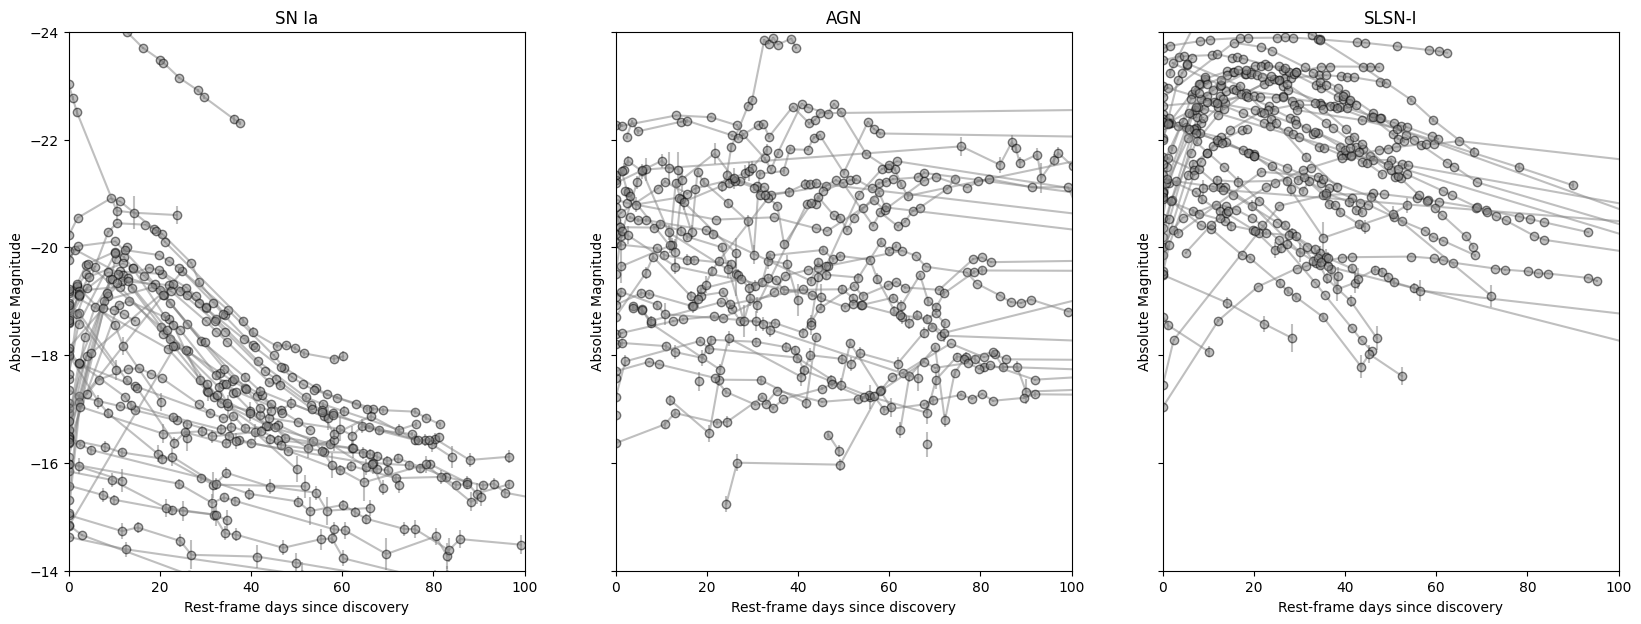

In [27]:
zpt = 27.5
merged_df = lcs_detected.merge(dftrain_metadata)
merged_df['abs_mag'] = zpt - 2.5*np.log10(merged_df['flux'].values) - merged_df['distmod']
merged_df['mag_err'] = 1.0857 * np.abs(merged_df['flux_err'].values/merged_df['flux'].values)

fig, axs = plt.subplots(1,3, figsize=(20,7), sharey=True, sharex=True);
axs = axs.ravel()
tClasses = ['SN Ia', 'AGN', 'SLSN-I']

band = 'r'
for i in np.arange(len(tClasses)):
    tClass = tClasses[i]
    transientDF = merged_df[merged_df['target_names'] == tClass]
    for transient_id in np.unique(transientDF['object_id'])[0:50]:
        lc = transientDF[transientDF['object_id'] == transient_id]
        lc_band = lc[lc['passband_name'] == band]
        axs[i].errorbar((lc_band['mjd'] - np.nanmin(lc['mjd']))/(1+lc_band['hostgal_photoz']), lc_band['abs_mag'], yerr=lc_band['mag_err'], fmt='o-', mec='k', c='gray', label=band, alpha=0.5)
        axs[i].set_xlabel("Rest-frame days since discovery")
        axs[i].set_ylabel("Absolute Magnitude")
        axs[i].set_title(tClasses[i])
axs[0].set_xlim((0, 100));
axs[0].set_ylim((-14, -24));

We can see that timescale and peak absolute magnitude are often key features used to distinguish between transient classes, a first step at finding those with anomalous photometric behavior. 

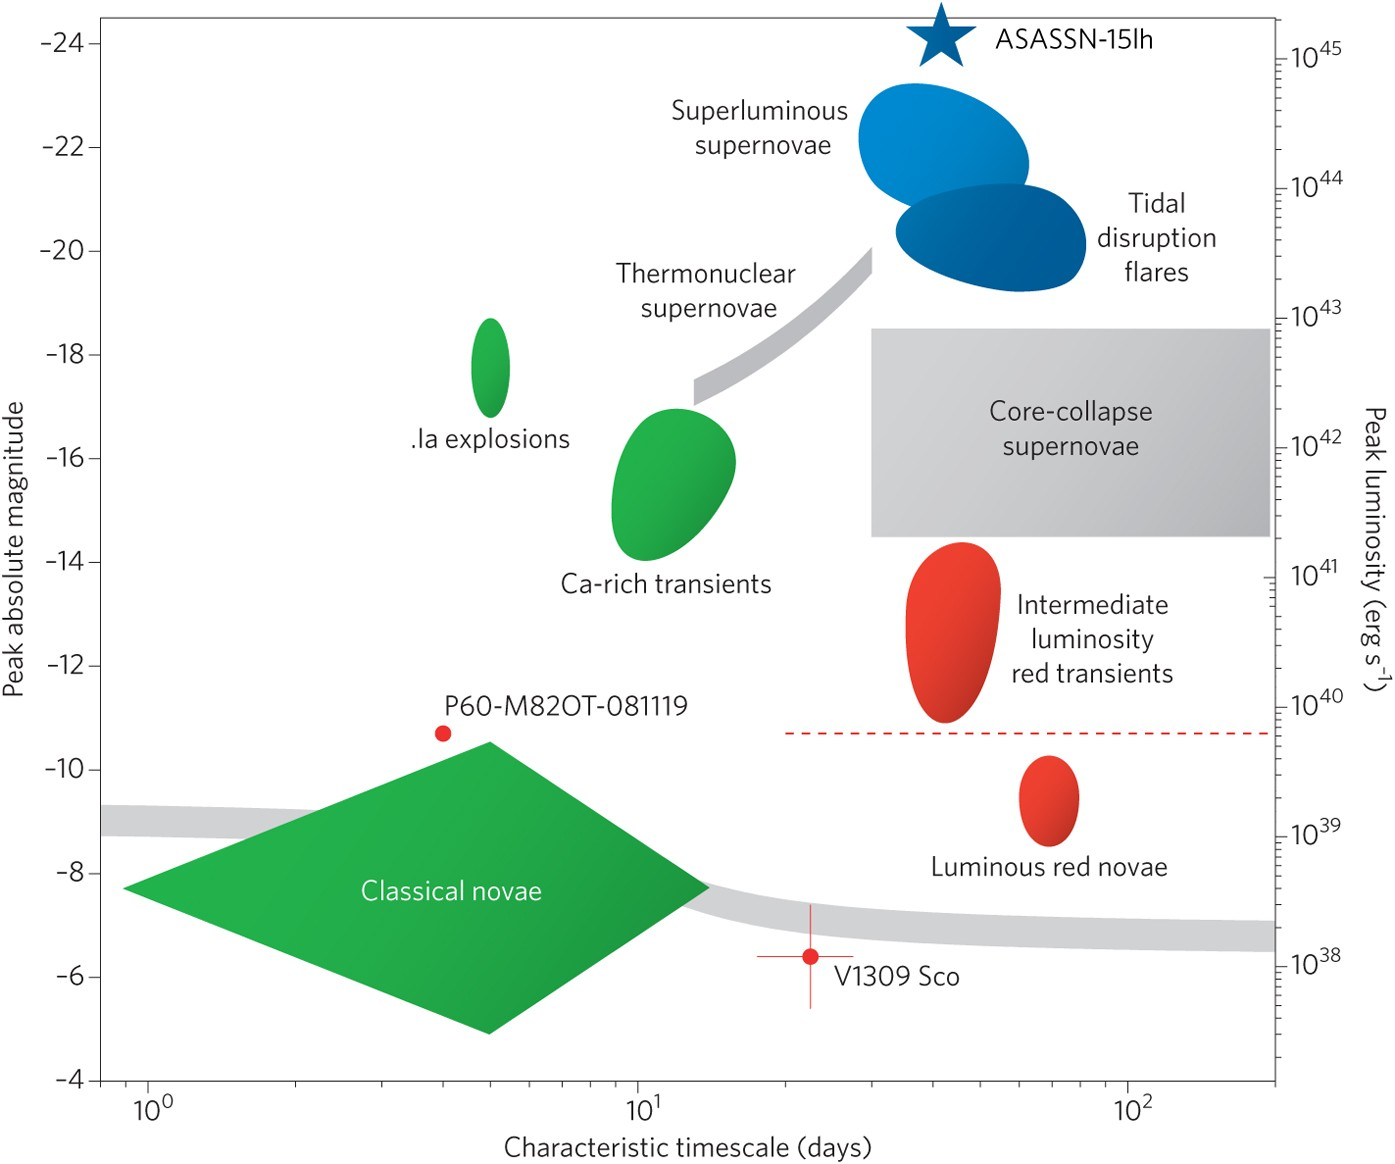

In [28]:
Image(filename='../plots/ParamSpace.jpeg', width=1024)

Let's see how our test set for the PLAsTiCC challenge compares to the training set: 

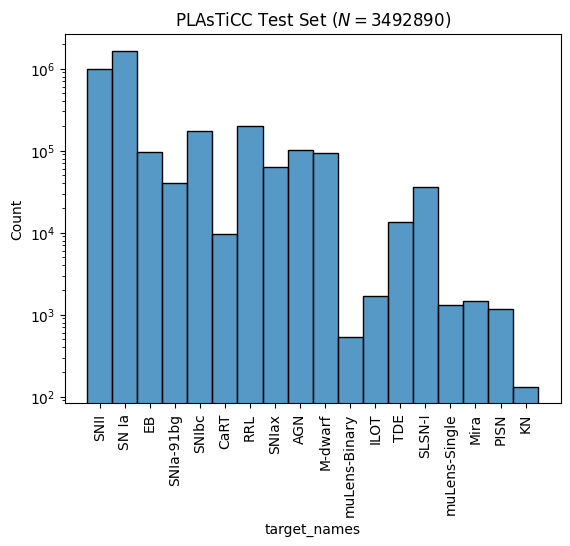

In [29]:
dftest_metadata = pd.read_csv("../data/plasticc_test_metadata.csv")

dftest_metadata['target_names'] = dftest_metadata['true_target'].map(model_nums)

sns.histplot(dftest_metadata['target_names'])
plt.yscale("log")
plt.xticks(rotation=90);
plt.title("PLAsTiCC Test Set ($N=%i$)"%len(dftest_metadata));

In the PLAsTiCC challenge, the test set contains nearly 3.5 _million_ events! We can see that the test set contains some novel classes, such as Pair-Instability Supernovae (in reality we have only candidates to date, none confirmed!) and Calcium-Rich Transients (a few confirmed, but rare). 

We've downloaded the metadata and the first two light curve files here. 

In [30]:
lcs_test = pd.read_csv("../data/plasticc_test_lightcurves_02.csv")

/var/folders/y1/n43fk0m97tg8sbqh5j222kqw0000gn/T/ipykernel_91191/137377566.py:6: RuntimeWarning: invalid value encountered in log10
  merged_df['apparent_mag'] = zpt - 2.5*np.log10(merged_df['flux'].values)
/Users/alexgagliano/miniconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/alexgagliano/miniconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


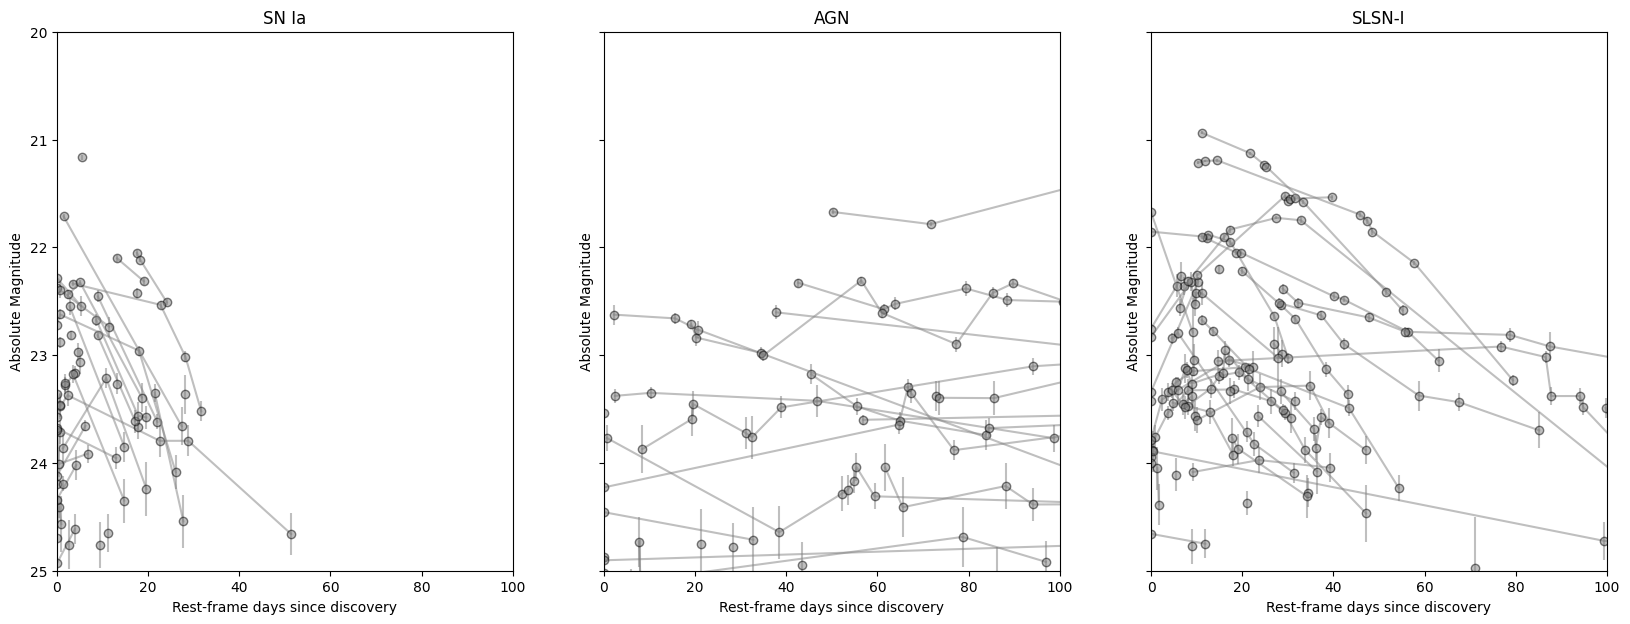

In [31]:
lcs_test['passband_name'] = ["ugrizY"[i] for i in lcs_test['passband']]

zpt = 27.5
lcs_detected = lcs_test[lcs_test['detected_bool'] == 1]
merged_df = lcs_detected.merge(dftest_metadata)
merged_df['apparent_mag'] = zpt - 2.5*np.log10(merged_df['flux'].values) 
merged_df['mag_err'] = 1.0857 * np.abs(merged_df['flux_err'].values/merged_df['flux'].values)

fig, axs = plt.subplots(1,3, figsize=(20,7), sharey=True, sharex=True);
axs = axs.ravel()
tClasses = ['SN Ia', 'AGN', 'SLSN-I']

for i in np.arange(len(tClasses)):
    tClass = tClasses[i]
    transientDF = merged_df[merged_df['target_names'] == tClass]
    for transient_id in np.unique(transientDF['object_id'])[0:50]:
        lc = transientDF[transientDF['object_id'] == transient_id]
        band = 'r'
        lc_band = lc[lc['passband_name'] == band]
        axs[i].errorbar((lc_band['mjd'] - np.nanmin(lc['mjd']))/(1+lc_band['hostgal_photoz']), lc_band['apparent_mag'], yerr=lc_band['mag_err'], fmt='o-', mec='k', c='gray', label=band, alpha=0.5)
        axs[i].set_xlabel("Rest-frame days since discovery")
        axs[i].set_ylabel("Absolute Magnitude")
        axs[i].set_title(tClasses[i])
axs[0].set_xlim((0, 100));
axs[0].set_ylim((25, 20));

The light curves certainly look worse than the training set, and this was intentional. The training set is designed to not be representative of the full test set: it is biased toward brighter events, and does not contain transient classes that are in the test set. How can we train our deep learning algorithms to be robust against this distribution shift to find novel events in the messier data?

That's all for now. For a more extensive introduction to PLAsTiCC, Rubin operations, and time-domain astrophysics as a whole, I highly recommend checking out the [PLAsTiCC starter kit](https://www.kaggle.com/code/michaelapers/the-plasticc-astronomy-starter-kit). 